# Imports

In [1]:
import pandas as pd
import numpy as np
import shap
import plotly.graph_objs as go
from lightgbm import LGBMClassifier  # Scikit-learn API
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TunedThresholdClassifierCV
from sklearn.metrics import f1_score

from project_ml_course.data_process import filter_columns_by_correlation_threshold

/Users/vitor.mello/vho/project_ml_course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model with almost all features

In [2]:
raw_df = pd.read_csv("../data/dados.csv", index_col="Unnamed: 0")

df = filter_columns_by_correlation_threshold(
    df=raw_df,
    ref_col="class",
    method_type="pearson",
    lower_threshold=0.001,
    higher_threshold=0.999,
)

X = df.drop(columns=["class"])
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, stratify=y
)

base_pipeline = Pipeline(
    [
        ("clf", LGBMClassifier(verbose=-1, random_state=42)),
    ]
)

model = TunedThresholdClassifierCV(
    estimator=base_pipeline,
    thresholds=np.arange(0, 1.0, 0.01),
    cv=5,
    scoring="f1",
    random_state=42,
    store_cv_results=True,
)

_ = model.fit(X_train, y_train)

f1_score(y_test, model.predict(X_test))

0.9717868338557993

In [3]:
# 5. SHAP com KernelExplainer
explainer = shap.KernelExplainer(model.predict, X_train.sample(n=100))
shap_values = explainer(X_test.sample(n=50))

/Users/vitor.mello/vho/project_ml_course/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
  0%|          | 0/50 [00:00<?, ?it/s]/Users/vitor.mello/vho/project_ml_course/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/vitor.mello/vho/project_ml_course/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
  2%|▏         | 1/50 [00:00<00:07,  6.16it/s]/Users/vitor.mello/vho/project_ml_course/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/vitor

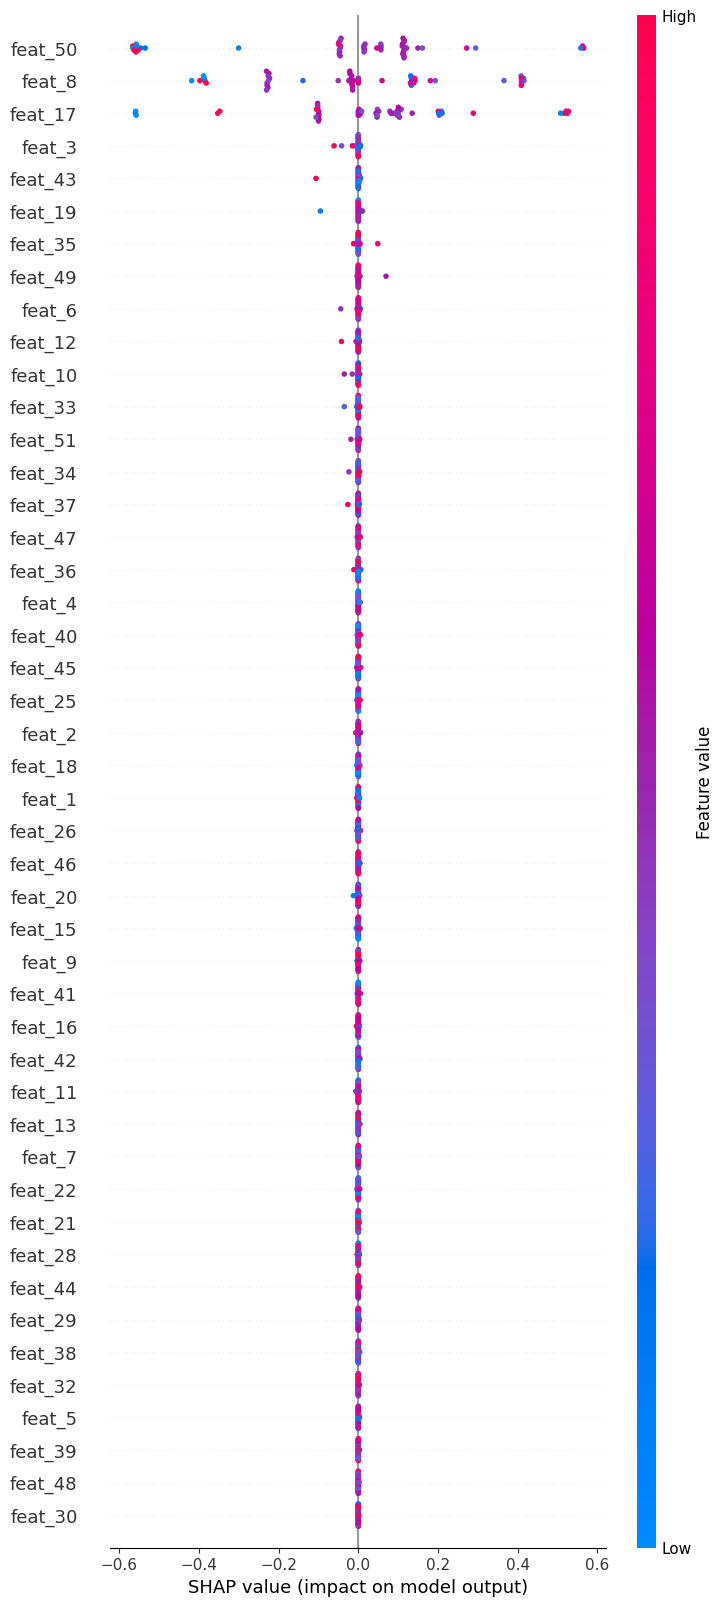

In [4]:
# 6. Visualizar
shap.initjs()
shap.plots.beeswarm(shap_values, max_display=X_train.shape[1])

# Model w/ 3 features

In [5]:
raw_df = pd.read_csv("../data/dados.csv", index_col="Unnamed: 0")

df = filter_columns_by_correlation_threshold(
    df=raw_df,
    ref_col="class",
    method_type="pearson",
    lower_threshold=0.001,
    higher_threshold=0.999,
)

X = df[["feat_8", "feat_50", "feat_17"]]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, stratify=y
)

base_pipeline = Pipeline(
    [
        ("clf", LGBMClassifier(verbose=-1, random_state=42)),
    ]
)

model = TunedThresholdClassifierCV(
    estimator=base_pipeline,
    thresholds=np.arange(0, 1.0, 0.01),
    cv=5,
    scoring="f1",
    random_state=42,
    store_cv_results=True,
)

_ = model.fit(X_train, y_train)

f1_score(y_test, model.predict(X_test))

0.9777777777777777

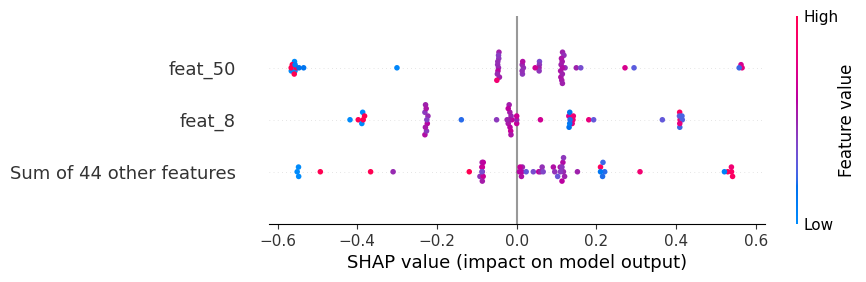

In [6]:
# 6. Visualizar
shap.initjs()
shap.plots.beeswarm(shap_values, max_display=X_train.shape[1])

# Plod 3D

In [7]:
y_pred = model.predict(X_test)
y_true = y_test.values

# Mapear cor para predição SVM (0: azul, 1: vermelho)
color_map = np.array(["blue", "red"])
colors = color_map[y_pred]

# Mapear símbolo para target (0: círculo, 1: diamante)
symbol_map = np.array(["circle", "diamond"])
symbols = symbol_map[y_true]

# Traço para pontos de teste, shape pelo target, cor pela predição SVM
test_trace = go.Scatter3d(
    x=X_test.iloc[:, 0],
    y=X_test.iloc[:, 1],
    z=X_test.iloc[:, 2],
    mode="markers",
    marker=dict(
        size=7, color=colors, symbol=symbols, line=dict(width=1, color="black")
    ),
    name="Test points (shape=target, color=SVM pred)",
)

layout = go.Layout(
    scene=dict(
        xaxis_title="feat_8",
        yaxis_title="feat_50",
        zaxis_title="feat_17",
    ),
    title="Pontos de teste no espaço das três principais features",
    legend=dict(x=0.01, y=0.99),
)

fig = go.Figure(data=[test_trace], layout=layout)
fig.show()
